# Time Series Analysis

This part introduces how to perform time series analysis among multi samples [[Fang23]](https://doi.org/10.1101/2023.12.04.569485).

1. Using `paga` method to find out time seires samples' developmental trajectory.
2. Using `time_series_analysis` method to find essentail genes during development.

Download the demo data [Time Series Developing Mouse Brain](http://116.6.21.110:8090/share/c5d9e7f3-7d66-4154-87e1-a740f4bb4dbc).

This Data is the embyro developing mouse brain from E9.5 to E16.5.

## MSData construction

In [5]:
import os
import stereo as st
from natsort import natsorted
from stereo.core.ms_pipeline import slice_generator
from stereo.core.ms_data import MSData

data_dir = "../data/Embyro/"

file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
file_list = natsorted(file_list)

# reading all slices
ms_data = MSData()
for f in file_list:
    ms_data += st.io.read_h5ad(f)
    
# change slides name
slides = ['E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5', 'E14.5', 'E15.5', 'E16.5']
ms_data.names = slides

## Integrate

In [6]:
ms_data.integrate() 
# ms_data.merged_data.position = ms_data.merged_data.position * 100

ms_data.tl.raw_checkpoint()

# preprocessing
ms_data.tl.normalize_total()
ms_data.tl.log1p()

# embedding
ms_data.tl.pca(svd_solver='arpack', n_pcs=20)
ms_data.tl.neighbors(n_neighbors=15, n_jobs=-1, pca_res_key='pca')

[2023-11-20 17:02:54][Stereo][157054][MainThread][139923996649280][ms_pipeline][131][INFO]: data_obj(idx=0) in ms_data start to run raw_checkpoint
[2023-11-20 17:03:09][Stereo][157054][MainThread][139923996649280][ms_pipeline][131][INFO]: data_obj(idx=0) in ms_data start to run normalize_total
[2023-11-20 17:03:09][Stereo][157054][MainThread][139923996649280][st_pipeline][41][INFO]: start to run normalize_total...
[2023-11-20 17:04:32][Stereo][157054][MainThread][139923996649280][st_pipeline][44][INFO]: normalize_total end, consume time 81.4425s.
[2023-11-20 17:04:32][Stereo][157054][MainThread][139923996649280][ms_pipeline][131][INFO]: data_obj(idx=0) in ms_data start to run log1p
[2023-11-20 17:04:32][Stereo][157054][MainThread][139923996649280][st_pipeline][41][INFO]: start to run log1p...
[2023-11-20 17:04:45][Stereo][157054][MainThread][139923996649280][st_pipeline][44][INFO]: log1p end, consume time 12.7426s.
[2023-11-20 17:04:45][Stereo][157054][MainThread][139923996649280][ms_p

Get annotation from single slice individually.

In [7]:
ms_data.to_integrate(scope=slice_generator[:],res_key='annotation',_from=slice_generator[:], type='obs',item=['annotation']*ms_data.num_slice)

[2023-11-14 14:15:38][Stereo][3568][MainThread][140375084926784][ms_pipeline][131][INFO]: data_obj(idx=0) in ms_data start to run cluster_scatter


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

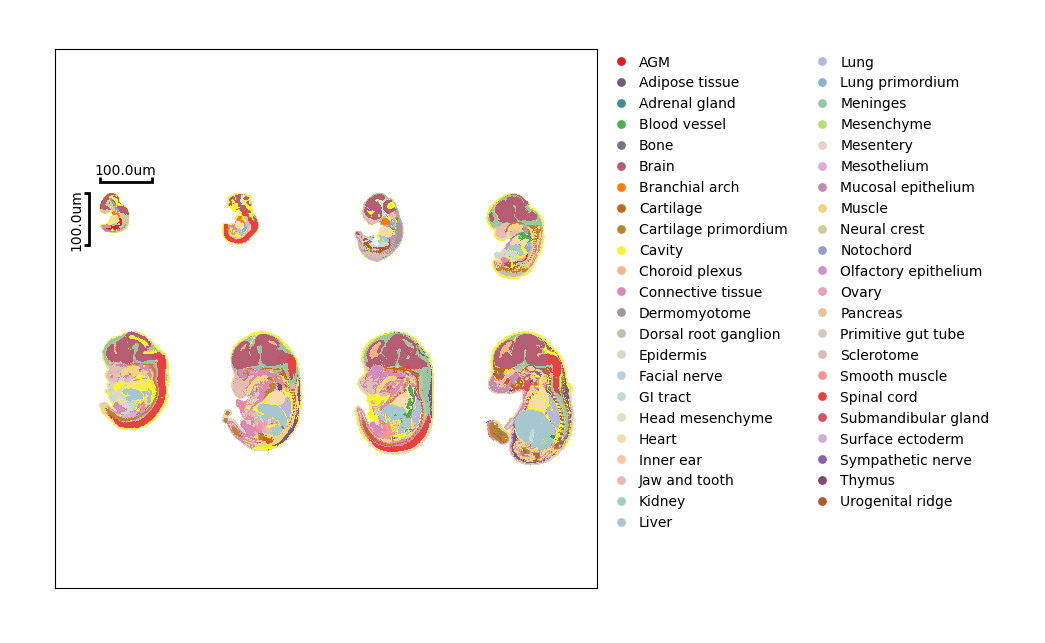

In [4]:
ms_data.plt.cluster_scatter(
    mode='integrate',
    scope=slice_generator[:],
    res_key='annotation',
    plotting_scale_width=200,        # the width of scale
    reorganize_coordinate=4,           # the number of plots in each row
    horizontal_offset_additional=200,  # adjustment for horizontal distance
    vertical_offset_additional=200     # adjustment for vertical distance
    )

## `PAGA` to infer trajectory

In [5]:
ms_data.tl.paga(groups='annotation')
ms_data

[2023-11-14 14:15:44][Stereo][3568][MainThread][140375084926784][ms_pipeline][121][INFO]: register algorithm paga to <class 'stereo.core.stereo_exp_data.StereoExpData'>-140373552494528


ms_data: {'E9.5': (5913, 23761), 'E10.5': (18408, 23761), 'E11.5': (30124, 23761), 'E12.5': (51365, 23761), 'E13.5': (77369, 23761), 'E14.5': (102519, 23761), 'E15.5': (113350, 23761), 'E16.5': (121767, 23761)}
num_slice: 8
names: ['E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5', 'E14.5', 'E15.5', 'E16.5']
obs: ['batch', 'annotation']
var: []
relationship: other
var_type: intersect to 23761
mss: ["scope_[0,1,2,3,4,5,6,7]:['pca', 'pca_variance_ratio', 'neighbors', 'annotation', 'paga']"]

## Optional `dpt` to decide trajectory direction

In [6]:
import numpy as np
ms_data.merged_data.tl.result['iroot'] = np.flatnonzero((ms_data.merged_data.cells['batch'] == '0') & (ms_data.merged_data.cells['annotation'] == 'Brain'))[2]
ms_data.tl.dpt(n_branchings=0)

[2023-11-14 14:16:28][Stereo][3568][MainThread][140375084926784][ms_pipeline][121][INFO]: register algorithm dpt to <class 'stereo.core.stereo_exp_data.StereoExpData'>-140373552494528
[2023-11-14 14:16:28][Stereo][3568][MainThread][140375084926784][main][989][WARNING]: Trying to run `tl.dpt` without prior call of `tl.diffmap`. Falling back to `tl.diffmap` with default parameters.
[2023-11-14 14:16:28][Stereo][3568][MainThread][140375084926784][main][21][INFO]: computing Diffusion Maps using n_comps=15(=n_dcs)
[2023-11-14 14:16:30][Stereo][3568][MainThread][140375084926784][struct][732][INFO]: finished
[2023-11-14 14:18:30][Stereo][3568][MainThread][140375084926784][struct][793][INFO]:     eigenvalues of transition matrix
    [1.         0.9999596  0.999865   0.99983835 0.9994691  0.999355
     0.9992294  0.9990097  0.99876636 0.9986292  0.9984732  0.998372
     0.99824995 0.9982127  0.998051  ]
[2023-11-14 14:18:30][Stereo][3568][MainThread][140375084926784][main][27][INFO]:     finish

In [7]:
ms_data

ms_data: {'E9.5': (5913, 23761), 'E10.5': (18408, 23761), 'E11.5': (30124, 23761), 'E12.5': (51365, 23761), 'E13.5': (77369, 23761), 'E14.5': (102519, 23761), 'E15.5': (113350, 23761), 'E16.5': (121767, 23761)}
num_slice: 8
names: ['E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5', 'E14.5', 'E15.5', 'E16.5']
obs: ['batch', 'annotation']
var: []
relationship: other
var_type: intersect to 23761
mss: ["scope_[0,1,2,3,4,5,6,7]:['pca', 'pca_variance_ratio', 'neighbors', 'annotation', 'paga', 'iroot', 'X_diffmap', 'diffmap_evals', 'dpt_pseudotime']"]

[2023-11-14 14:18:31][Stereo][3568][MainThread][140375084926784][ms_pipeline][128][INFO]: register plot_func paga_time_series_plot to <class 'stereo.core.stereo_exp_data.StereoExpData'>-140373552494528


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

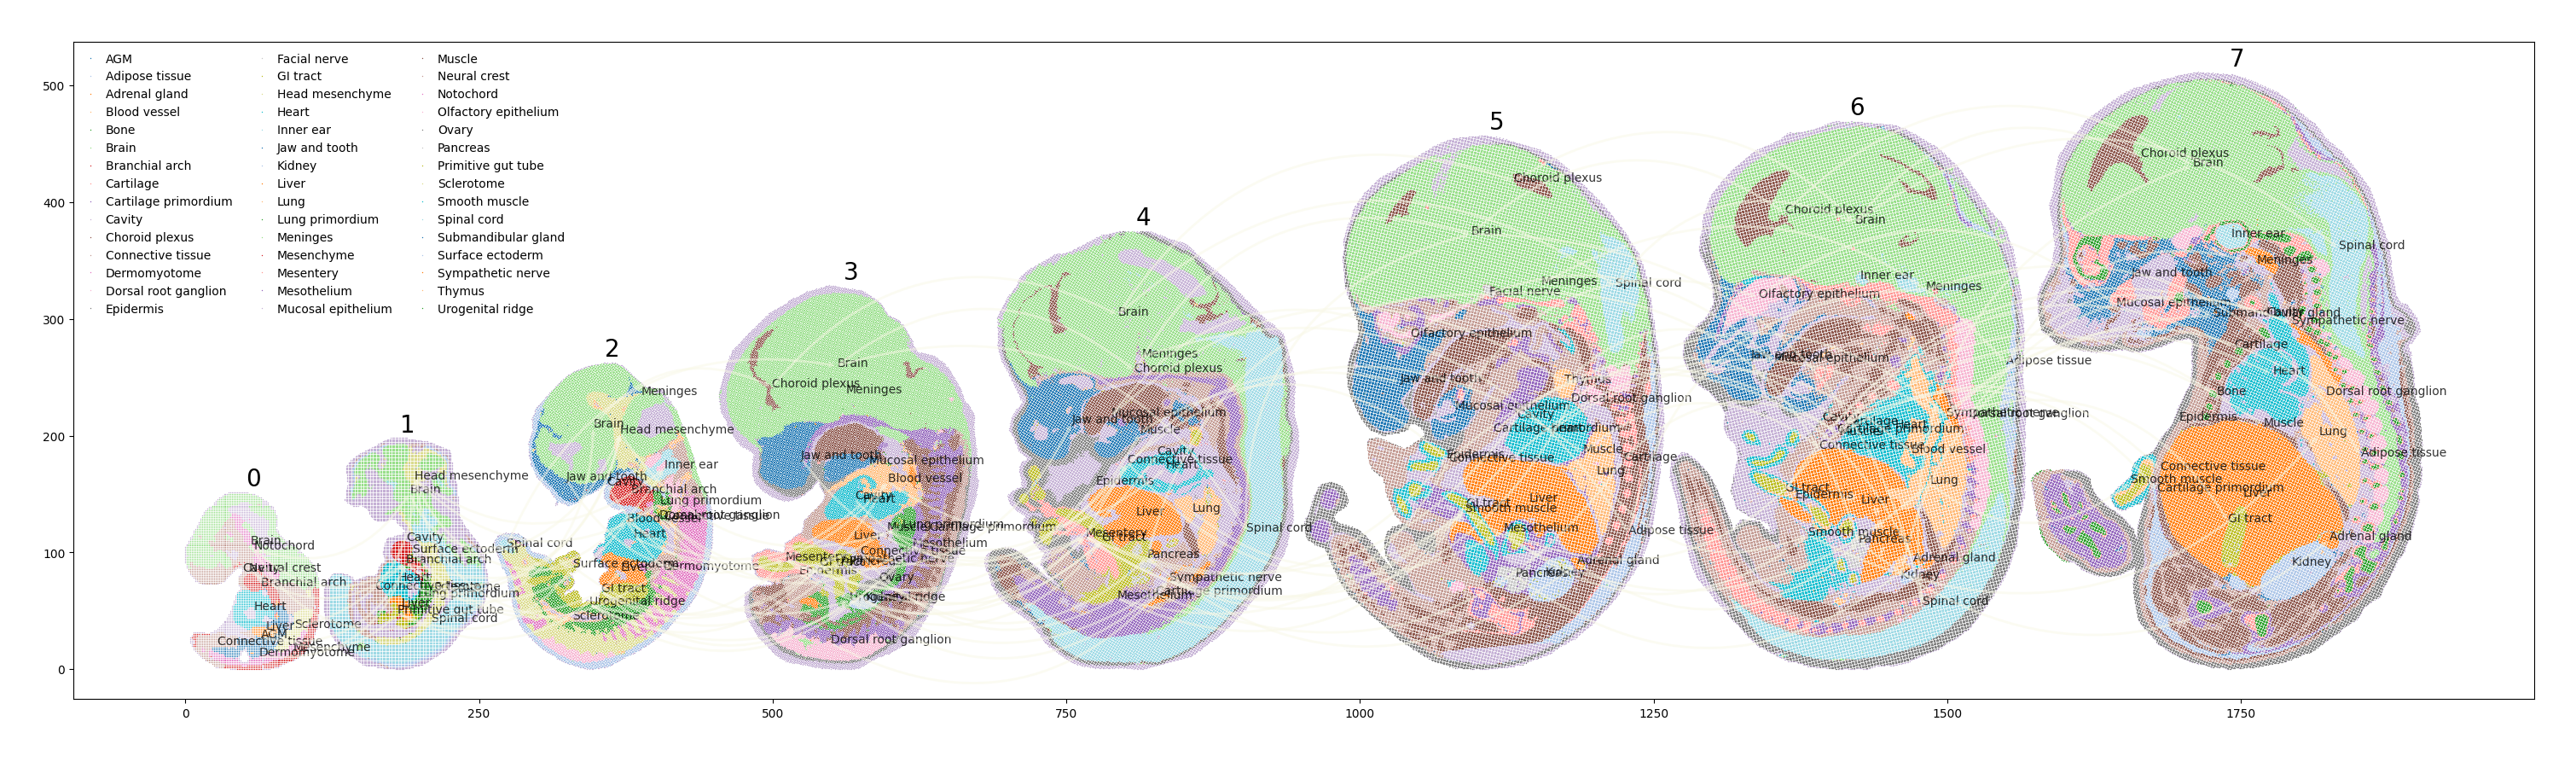

In [8]:
ms_data.plt.paga_time_series_plot(
        use_col='annotation',               
        batch_col='batch',   
        dpt_col='diffmap_evals', # this is optional
        height=10              
        )

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

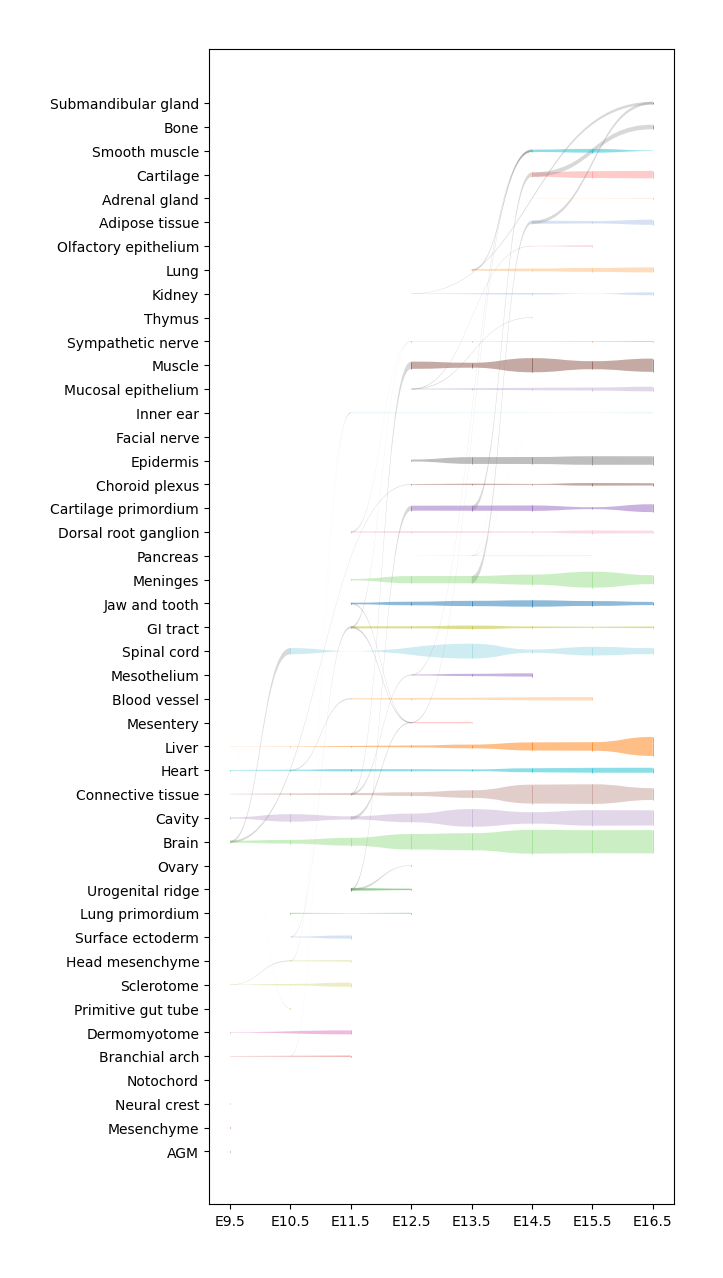

In [9]:
ms_data.plt.time_series_tree_plot(use_result='annotation', edges='paga', height=15)

## Temporal gene pattern for Serially up & down regulated genes

Stereopy also provide a method to explore the genes that highly correlated to the time point. The expression of gene exhibit a certain pattern along the time point. For example, you can use ```time_series_analysis``` to find up or down-regulated genes.


In [8]:
ms_data.tl.time_series_analysis(
                run_method='tvg_marker', 
                use_col='batch',                      
                branch=['0', '1', '2', '3', '4', '5', '6', '7'],                 
                p_val_combination='FDR'
                )

[2023-11-20 17:21:36][Stereo][157054][MainThread][139923996649280][ms_pipeline][121][INFO]: register algorithm time_series_analysis to <class 'stereo.core.stereo_exp_data.StereoExpData'>-139923659530352
INFO:numba.core.transforms:finding looplift candidates


### Top 3 serially down-regulated genes with lowest `less_pvalue`

In [9]:
ms_data.var.sort_values('less_pvalue').iloc[:3]

less_pvalue  greater_pvalue     logFC
Naa35    0.000000e+00             1.0 -0.239634
Igf2bp1  1.110223e-16             1.0 -0.411088
Uck2     2.990941e-13             1.0 -0.223973

### Top 3 serially up-regulated genes with lowest `greater_pvalue`

In [12]:
ms_data.var.sort_values('greater_pvalue').iloc[:3]

less_pvalue  greater_pvalue     logFC
Trf            1.0    1.315614e-13  0.470321
Fga            1.0    5.891545e-06  0.756051
Hif3a          1.0    1.324109e-01  0.331680

[2023-11-20 18:09:42][Stereo][157054][MainThread][139923996649280][ms_pipeline][128][INFO]: register plot_func boxplot_transit_gene to <class 'stereo.core.stereo_exp_data.StereoExpData'>-139923659530352


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

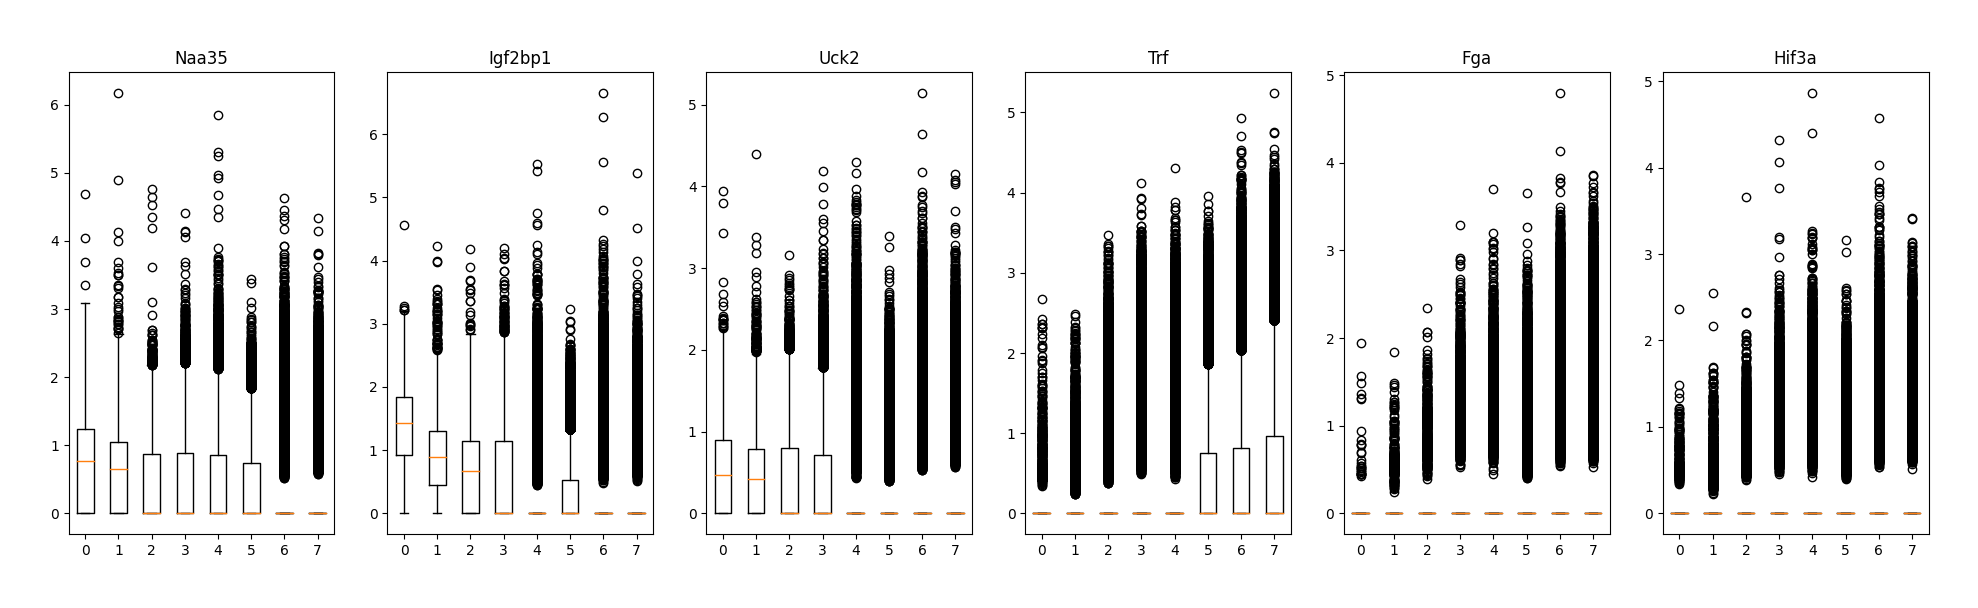

In [10]:
ms_data.plt.boxplot_transit_gene(
    use_col='batch',
    branch=['0', '1', '2', '3', '4', '5', '6', '7'],
    genes=['Naa35', 'Igf2bp1', 'Uck2', 'Trf', 'Fga', 'Hif3a']
    )

### Fuzzy'C means to cluster genes on spatial & temporal pattern

Except for up or down regulated genes, there is other expression pattern also important. Stereopy use consider both temporal and spatial information and based on which cluster genes into serveral groups.

In [15]:
ms_data.tl.time_series_analysis(
    run_method='other', 
    cluster_number=6, 
    spatial_weight=1, 
    n_spatial_feature=2,
    temporal_mean_threshold=0.85, 
    temporal_top_threshold=1, 
    Epsilon=1e-15,
    )

[2023-11-21 08:37:24][Stereo][157054][MainThread][139923996649280][ms_pipeline][121][INFO]: register algorithm time_series_analysis to <class 'stereo.core.stereo_exp_data.StereoExpData'>-139923659530352


epoch 100 : time cosumed1.9185s, loss:1.537990590438909e-08
epoch 200 : time cosumed1.9003s, loss:4.801714581503802e-13


[2023-11-21 09:21:59][Stereo][157054][MainThread][139923996649280][ms_pipeline][128][INFO]: register plot_func fuzz_cluster_plot to <class 'stereo.core.stereo_exp_data.StereoExpData'>-139923659530352


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

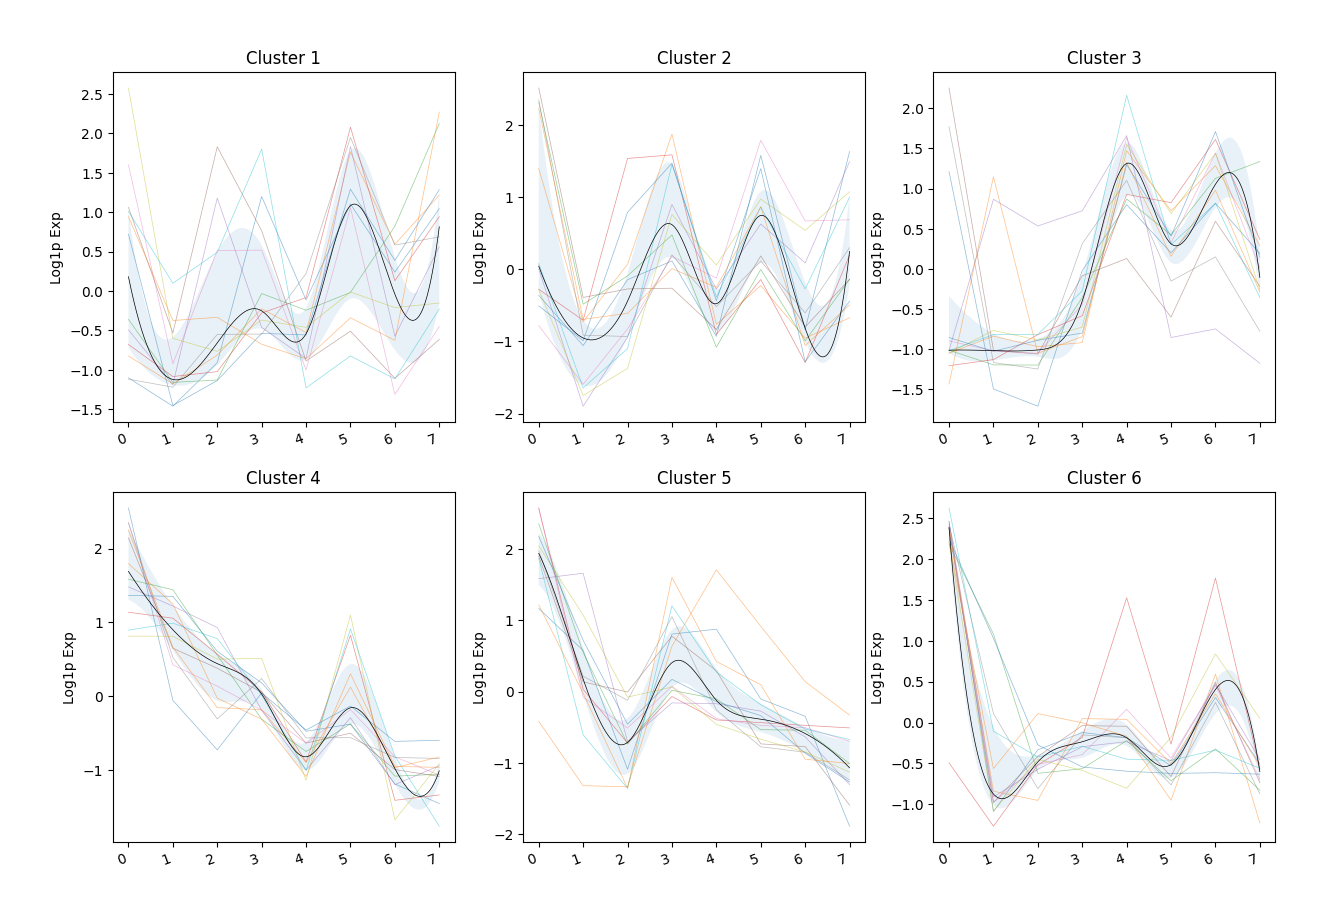

In [17]:
ms_data.plt.fuzz_cluster_plot(
        use_col='batch',
        branch=['0', '1', '2', '3', '4', '5', '6', '7'], 
        threshold = 'p99.95',
        n_col = 3, 
        summary_trend=True, 
        width = None, 
        height = None
        )

### A volcano plot to visualize all genes expression on timepoints

The scatter size indicates the expression level of each gene on each time point.

[2023-11-14 16:11:07][Stereo][3568][MainThread][140375084926784][ms_pipeline][128][INFO]: register plot_func TVG_volcano_plot to <class 'stereo.core.stereo_exp_data.StereoExpData'>-140373552494528
INFO:numba.core.transforms:finding looplift candidates


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

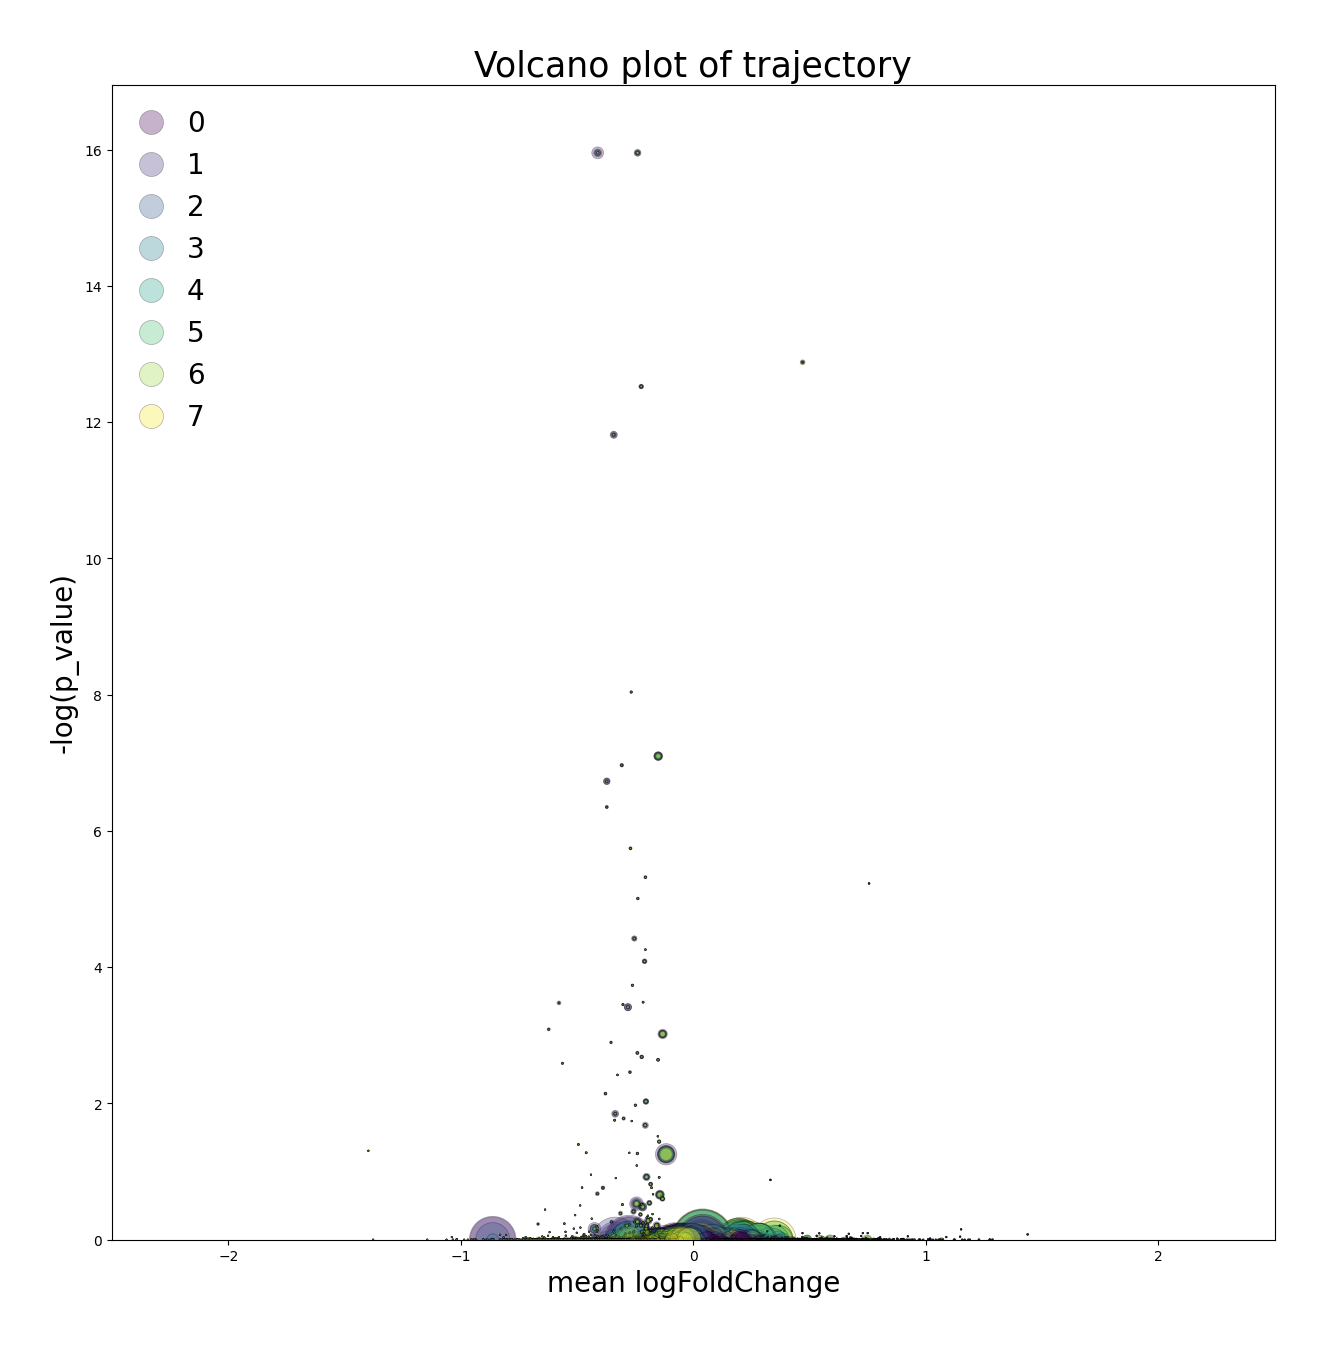

In [16]:
ms_data.plt.TVG_volcano_plot(use_col='batch', branch=['0', '1', '2', '3', '4', '5', '6', '7'])

## Distribution of marker genes over pseudotime

In [17]:
ms_data.tl.find_marker_genes(cluster_res_key='annotation', method='t_test', use_highly_genes=False, use_raw=True, res_key='marker_genes')

[2023-11-14 16:56:43][Stereo][3568][MainThread][140375084926784][ms_pipeline][131][INFO]: data_obj(idx=0) in ms_data start to run find_marker_genes
[2023-11-14 16:56:43][Stereo][3568][MainThread][140375084926784][st_pipeline][41][INFO]: start to run find_marker_genes...
[2023-11-14 16:56:44][Stereo][3568][MainThread][140375084926784][tool_base][122][INFO]: read group information, grouping by group column.
[2023-11-14 16:56:44][Stereo][3568][MainThread][140375084926784][tool_base][151][INFO]: start to run...
[2023-11-14 16:56:44][Stereo][3568][MainThread][140375084926784][time_consume][57][INFO]: start to run calc_pct_and_pct_rest...
[2023-11-14 16:59:24][Stereo][3568][MainThread][140375084926784][time_consume][60][INFO]: calc_pct_and_pct_rest end, consume time 159.6446s.
[2023-11-14 17:16:58][Stereo][3568][MainThread][140375084926784][tool_base][153][INFO]: end to run.
[2023-11-14 17:16:58][Stereo][3568][MainThread][140375084926784][st_pipeline][44][INFO]: find_marker_genes end, consum

[2023-11-14 17:16:58][Stereo][3568][MainThread][140375084926784][ms_pipeline][128][INFO]: register plot_func plot_genes_in_pseudotime to <class 'stereo.core.stereo_exp_data.StereoExpData'>-140373552494528


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

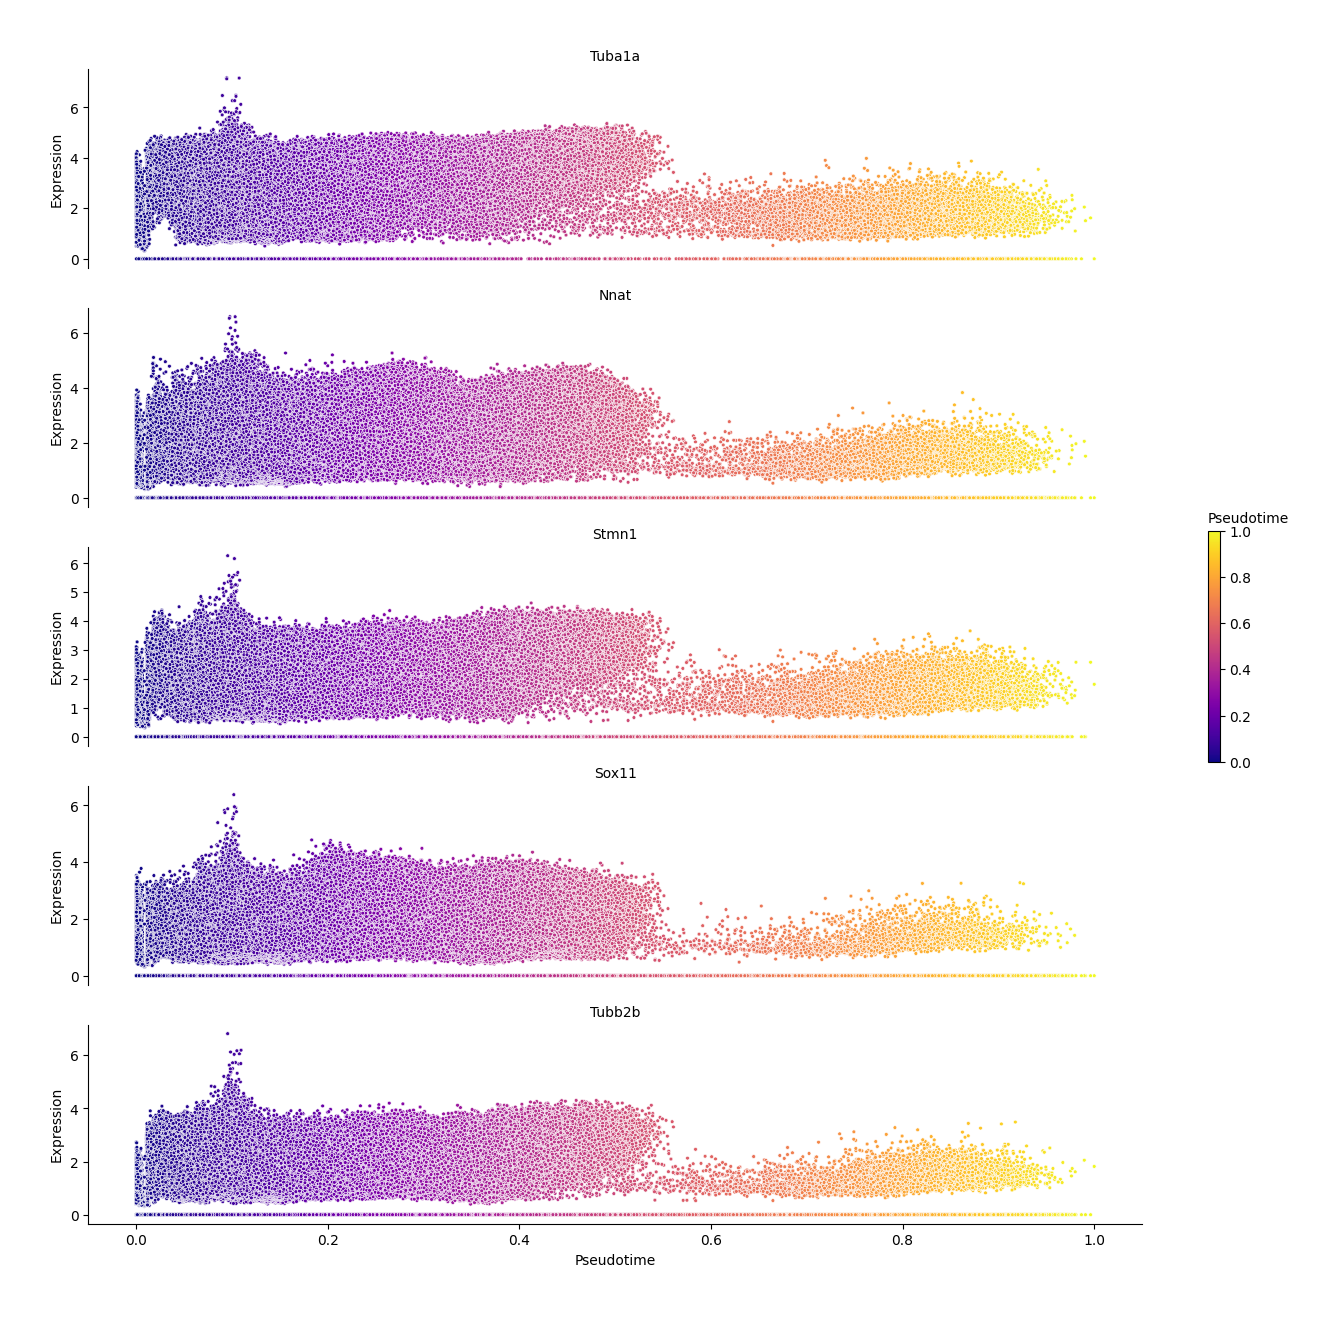

In [18]:
ms_data.plt.plot_genes_in_pseudotime(
    marker_genes_res_key='marker_genes',
    group='Brain',
    topn=5
    )